In [1]:
import numpy as np
import h5py
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib import gridspec
from matplotlib.colors import colorConverter
plt.rc('text', usetex=True)

import seaborn as sns

import glob
import os
import pickle
import sys

from astropy.table import Table


In [2]:
from colossus.halo import mass_adv
from colossus.cosmology import cosmology
cosmology.setCosmology('planck18')

In [3]:
def open_pkl(file_name):
    pkl = open(file_name,'rb')
    array = pickle.load(pkl)#, encoding='latin')
    pkl.close()  
    return array

In [4]:
def get_median(bins, x, y):
    
    x_y =np.vstack([x,y])
    
    bins_y=[]
    bins_x=[]
    
    err_y=[]
    err_x=[]
    
    for i in range(len(bins)-1):
        l=bins[i]
        u=bins[i+1]
        
        mask = [(x_y[0]>l) & (x_y[0]<u)]

        y_in_range = x_y[1][mask]
        x_in_range = x_y[0][mask]
        
        print('{0} galaxies in this bin'.format(len(y_in_range)))
        
#         print(len(y_in_range))
        
        bins_y.append(np.median(y_in_range))
        bins_x.append(np.median(x_in_range))
        
#         err_y.append(np.std(y_in_range)/np.sqrt(len(y_in_range)))
#         err_x.append(np.std(x_in_range)/np.sqrt(len(x_in_range)))
        
    #error on the mean
        err_y.append(np.std(10**y_in_range)/np.sqrt(len(y_in_range)))
        err_x.append(np.std(10**x_in_range)/np.sqrt(len(x_in_range)))
        
        
    bins_y, bins_x, err_y, err_x =  np.array(bins_y), np.array(bins_x), np.array(err_y), np.array(err_x)
    

    
        
    return bins_x, bins_y, err_x, err_y
               
    
def errors_for_plots(bins_x, bins_y, err_x, err_y):
       
    upper_err_y= np.log10(10**bins_y + err_y) - bins_y
    lower_err_y= bins_y - np.log10(10**bins_y - err_y)
    upper_err_x= np.log10(10**bins_x + err_x) - bins_x
    lower_err_x= bins_x - np.log10(10**bins_x - err_x)
    
    return [lower_err_x,upper_err_x], [lower_err_y,upper_err_y]

In [12]:
def make_Mstar_Mhalo_plot(HSC_data, mass_radius, Illustris_data=None, TNG_data=None, output_filename=None):
    
    mass_bins = np.linspace(13.0,14.25,4)
    
    fig = plt.figure(figsize=[10,10])

    #hsc
    hsc_mvir = np.array(HSC_data['m_vir'])
    
    if mass_radius == 'outer':
        hsc_mstar = np.array(np.log10(10**HSC_data['m_100']-10**HSC_data['m_30']))
        hsc_mvir = hsc_mvir[~np.isinf(hsc_mstar)]
        hsc_mstar = hsc_mstar[~np.isinf(hsc_mstar)]
        
    else:
        hsc_mstar = np.array(HSC_data['m_{0}'.format(mass_radius)])

    sns.kdeplot(hsc_mvir, hsc_mstar, cmap="Greys", shade=True, shade_lowest=False, legend=False,  n_levels=7,
                zorder =1, colors=None)
    contours_ax = sns.kdeplot(hsc_mvir, hsc_mstar, colors='grey', cmap=None, shade_lowest=False,
                              n_levels=7, linewidths=1)
    
    #only show scatter points outside the contours: https://stackoverflow.com/questions/19311957/plot-contours-for-the-densest-region-of-a-scatter-plot
    inside = np.full_like(hsc_mvir,False,dtype=bool)
    for level in contours_ax.collections[1].get_paths():
        inside |= level.contains_points(zip(*(hsc_mvir, hsc_mstar)))
    plt.scatter(hsc_mvir[~inside], hsc_mstar[~inside], marker='o', color='k',
                s=1, linewidth=0, alpha=0.5, zorder=0)
    ############

    bins_x_hsc, bins_y_hsc, err_x_hsc, err_y_hsc = get_median(mass_bins,hsc_mvir, hsc_mstar)
#     plt.plot(bins_x_hsc, bins_y_hsc, markersize=20, color=colorConverter.to_rgba('k', alpha=.4),
#              linewidth=5, marker='s', zorder=5, markeredgecolor=colorConverter.to_rgba('k', alpha=1), 
#              markeredgewidth=3, label='HSC') #medians

    plot_err_x_hsc, plot_err_y_hsc = errors_for_plots(bins_x_hsc, bins_y_hsc, err_x_hsc, err_y_hsc)
    plt.errorbar(bins_x_hsc, bins_y_hsc, plot_err_x_hsc, plot_err_y_hsc, markersize=25,
                 color=colorConverter.to_rgba('k', alpha=0.5),
                 linewidth=5, marker='.', zorder=6, markerfacecolor =colorConverter.to_rgba('k', alpha=1),
                     markeredgecolor =colorConverter.to_rgba('k', alpha=1), 
                     ecolor=colorConverter.to_rgba('k', alpha=1), label=r'$\mathrm{HSC}$')
    
    if Illustris_data:
        illustris_mvir = np.array(Illustris_data['m_vir'])
        if mass_radius == 'outer':
            illustris_mstar = np.array(np.log10(10**Illustris_data['m_1d_100']-10**Illustris_data['m_1d_30']))
        else:
            illustris_mstar = np.array(Illustris_data['m_1d_{0}'.format(mass_radius)])
        plt.scatter(illustris_mvir, illustris_mstar, color=u'#d62728', s=30, linewidth=0, alpha=0.5,
                    zorder=5)
        bins_x_illustris, bins_y_illustris, err_x_illustris, err_y_illustris = get_median(mass_bins,
                                                                                          illustris_mvir,
                                                                                          illustris_mstar)
#         plt.plot(bins_x_illustris, bins_y_illustris, markersize=20,
#                  color=colorConverter.to_rgba(u'#d62728', alpha=.5), linewidth=5, marker='s', zorder=6,
#                  markeredgecolor=colorConverter.to_rgba(u'#d62728', alpha=1), markeredgewidth=3,
#                  label='Illustris')#medians
        plot_err_x_illustris, plot_err_y_illustris = errors_for_plots(bins_x_illustris, bins_y_illustris, err_x_illustris, err_y_illustris)
        plt.errorbar(bins_x_illustris, bins_y_illustris, plot_err_x_illustris, plot_err_y_illustris,
                     markersize=25,
                 color=colorConverter.to_rgba(u'#d62728', alpha=0.75),
                 linewidth=5, marker='.', zorder=6, markerfacecolor =colorConverter.to_rgba(u'#d62728', alpha=1),
                     markeredgecolor =colorConverter.to_rgba(u'#d62728', alpha=1), 
                     ecolor=colorConverter.to_rgba(u'#d62728', alpha=1),
                 label=r'$\mathrm{Illustris}$')#medians
        
    if TNG_data:
        tng_mvir = np.array(TNG_data['m_vir'])
        if mass_radius == 'outer':
            tng_mstar = np.array(np.log10(10**TNG_data['m_1d_100']-10**TNG_data['m_1d_30']))
        else:
            tng_mstar = np.array(TNG_data['m_1d_{0}'.format(mass_radius)])
        plt.scatter(tng_mvir, tng_mstar, color=u'#1f77b4', s=30, linewidth=0, zorder=5, alpha=0.5)
        
        bins_x_tng, bins_y_tng, err_x_tng, err_y_tng = get_median(mass_bins, tng_mvir, tng_mstar)
#         plt.plot(bins_x_tng, bins_y_tng, markersize=20, color=colorConverter.to_rgba(u'#1f77b4', alpha=.5),
#                  linewidth=5, marker='s', zorder=6, markeredgecolor=colorConverter.to_rgba('b', alpha=1),
#                 label='TNG', markeredgewidth=3)#medians
        
        plot_err_x_tng, plot_err_y_tng = errors_for_plots(bins_x_tng, bins_y_tng, err_x_tng, err_y_tng)
        plt.errorbar(bins_x_tng, bins_y_tng, plot_err_x_tng, plot_err_y_tng, markersize=25,
                     color=colorConverter.to_rgba(u'#1f77b4', alpha=0.75),
                 linewidth=5, marker='.', zorder=8, markerfacecolor =colorConverter.to_rgba(u'#1f77b4', alpha=1),
                     markeredgecolor =colorConverter.to_rgba(u'#1f77b4', alpha=1), 
                     ecolor=colorConverter.to_rgba(u'#1f77b4', alpha=1),
                label=r'$\mathrm{TNG}100$')#medians

    #PONOS
    if mass_radius == 'outer':
        ponos_v_mass = np.log10(10**ponos_v_masses['m_100'] - 10**ponos_v_masses['m_30'])
        ponos_sb_mass = np.log10(10**ponos_sb_masses['m_100'] - 10**ponos_sb_masses['m_30'])
    else:
        ponos_v_mass = ponos_v_masses['m_{0}'.format(mass_radius)]
        ponos_sb_mass = ponos_sb_masses['m_{0}'.format(mass_radius)]
        
    plt.scatter(ponos_m_vir, ponos_v_mass, c='#2ca02c', label=r'$\mathrm{PonosV}$', marker='^', s=200, zorder=10)
    plt.scatter(ponos_m_vir, ponos_sb_mass, c='#ff7f0e', label=r'$\mathrm{PonosSB}$', marker='^', s=200, zorder=10)
    
    #make cut to include M_100>11.5
    plt.axvline(13.0, c='grey', linewidth=1, linestyle='--')
    if mass_radius == 100:
        plt.axhline(11.2, c='grey', linewidth=1, linestyle='--')

    plt.xlabel('$\log (M_{\mathrm{vir}}/M_{\odot})$', fontsize=40)
    if mass_radius == 'outer':
        plt.ylabel(r'$\log (M_{{\star}}^{{100}} - M_{{\star}}^{{30}}/M_{\odot})$', fontsize=40)
    else:
        plt.ylabel(r'$\log (M_{{\star}}^{{ {0} }}/M_{{\odot}})$'.format(str(mass_radius)), fontsize=40, labelpad=5)

    plt.tick_params(axis='both', which='major', labelsize=30)

    plt.xlim([12,14.25])
    if mass_radius ==10:
        plt.ylim([10.7,12.1])
    elif mass_radius == 'outer':
        plt.ylim([9,12.2])
    else:
            plt.ylim([11,12.2])

    #legend
    lgnd = plt.legend(fontsize=30, scatterpoints=1, frameon=False)#, markerscale=2.)#, handler_map={hsc_points: HandlerLine2D(numpoints=3)})
    #change the marker size manually for both lines
#     lgnd.legendHandles[0]._sizes = [20.]
    
    if output_filename:
        fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/{0}'.format(output_filename),
                dpi=100, format='pdf', bbox_inches='tight')
    else:
        fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/Mhalo_vs_M{0}.pdf'.format(str(mass_radius)),
                    dpi=100, format='pdf', bbox_inches='tight', pad_inches=0.15) #pad_inches adds extra padding so superscript does not get cut off



    plt.show()
    
    return

# files

## simulations

In [6]:
illustris_masses_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/Illustris_masses_highres.pkl'
tng_masses_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/TNG_masses_highres.pkl'
illustris_masses = open_pkl(illustris_masses_file)
tng_masses = open_pkl(tng_masses_file)



In [7]:
#ponos
ponos_v_masses = {'m_10':11.74676299771465,  'm_30':11.835997387319807, 'm_100':11.88221989150391}
ponos_sb_masses = {'m_10':11.94239742523574, 'm_30':12.009701166202616, 'm_100':12.033305728795845}
ponos_m_vir = 13.02

### HSC

In [8]:
hsc_file = '/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/HSC/s16a_mass_good_mhalo_frac4_180503.fits'
hsc_table = Table.read(hsc_file)

In [9]:
hsc_m_vir_sr = hsc_table['logmh_vir_symbol']
hsc_m_vir_rf = hsc_table['logmh_vir_forest']

hsc_m100 = hsc_table['logm_100']
hsc_m30 = hsc_table['logm_30']
hsc_m10 = hsc_table['logm_10']

In [10]:
# HSC_data = {'m_vir':hsc_m_vir_sr[:100], 'm_100':hsc_m100[:10000], 'm_30':hsc_m30[:10000], 'm_10':hsc_m10[:10000]}
HSC_data = {'m_vir':hsc_m_vir_sr[:], 'm_100':hsc_m100[:], 'm_30':hsc_m30[:], 'm_10':hsc_m10[:]}

# PLOTS 

/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


9146 galaxies in this bin
2807 galaxies in this bin
638 galaxies in this bin
62 galaxies in this bin
23 galaxies in this bin
6 galaxies in this bin
82 galaxies in this bin
35 galaxies in this bin
13 galaxies in this bin


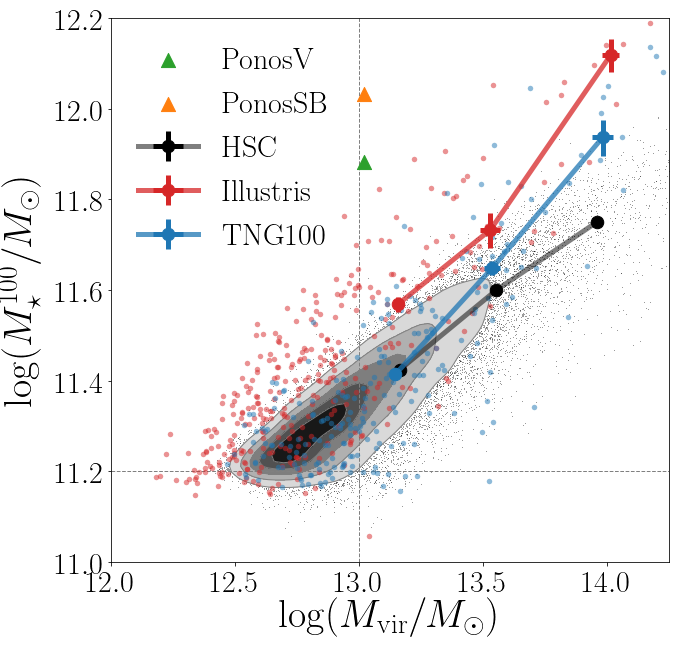

In [13]:
make_Mstar_Mhalo_plot(HSC_data,  100, Illustris_data = illustris_masses,
                     TNG_data = tng_masses)
                      

/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


9146 galaxies in this bin
2807 galaxies in this bin
638 galaxies in this bin
62 galaxies in this bin
23 galaxies in this bin
6 galaxies in this bin
82 galaxies in this bin
35 galaxies in this bin
13 galaxies in this bin


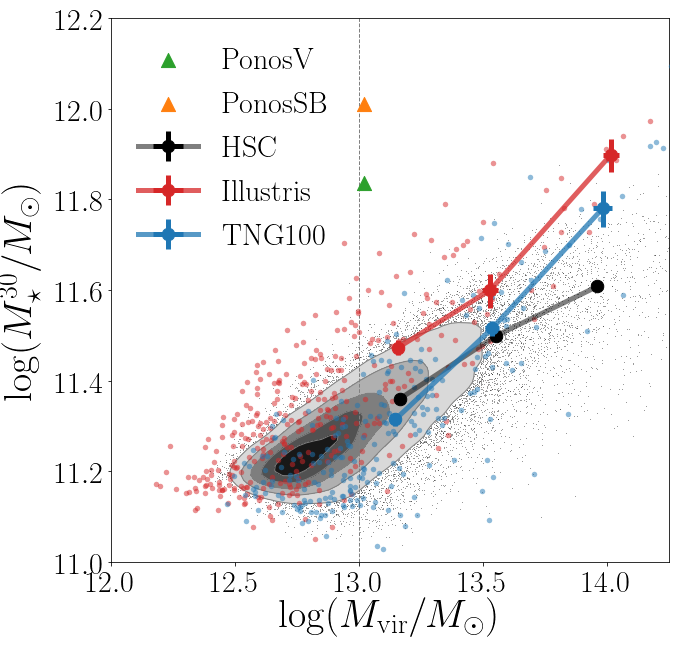

In [14]:
make_Mstar_Mhalo_plot(HSC_data, 30, Illustris_data = illustris_masses,
                     TNG_data = tng_masses)

/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


9146 galaxies in this bin
2807 galaxies in this bin
638 galaxies in this bin
62 galaxies in this bin
23 galaxies in this bin
6 galaxies in this bin
82 galaxies in this bin
35 galaxies in this bin
13 galaxies in this bin


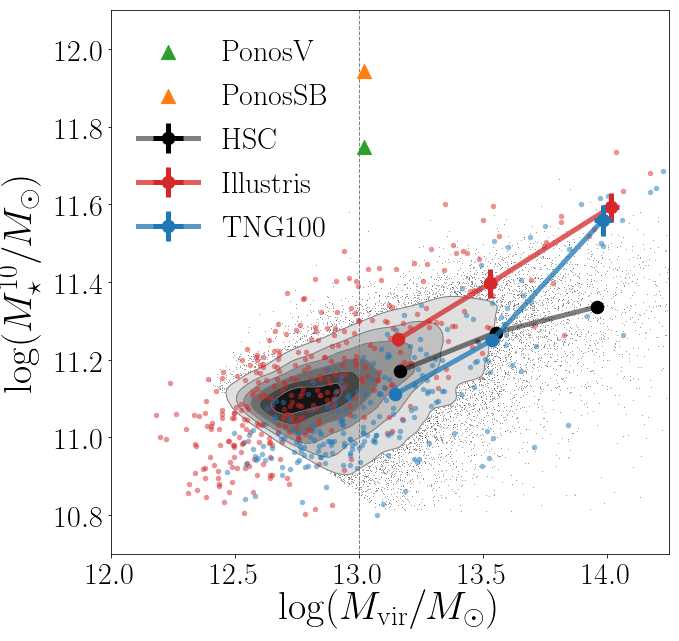

In [15]:
make_Mstar_Mhalo_plot(HSC_data,  10, Illustris_data = illustris_masses,
                     TNG_data = tng_masses)

/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/Users/fardila/anaconda/envs/hsc_hydro4/lib/python2.7/site-packages/ipykernel/__main__.py:18: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


9146 galaxies in this bin
2807 galaxies in this bin
638 galaxies in this bin
62 galaxies in this bin
23 galaxies in this bin
6 galaxies in this bin
82 galaxies in this bin
35 galaxies in this bin
13 galaxies in this bin


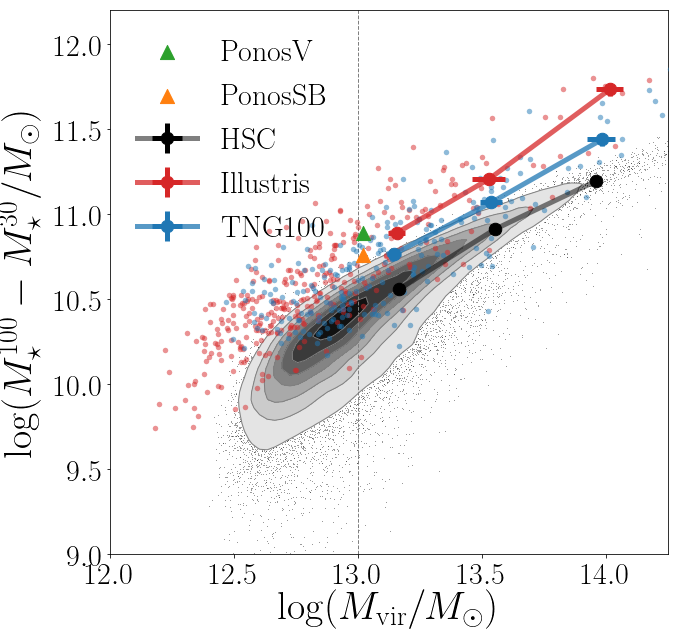

In [16]:
make_Mstar_Mhalo_plot(HSC_data,  'outer', Illustris_data = illustris_masses,
                     TNG_data = tng_masses)

## Quantifying differences

In [ ]:
def quantify_differences(mass_radius, mass_bins, bin_mass_type, hsc_data, sim_data, sim_name):

    print(sim_name)
    print('mass radius: {0}'.format(mass_radius))
    print('MASS BINS: {0}'.format(mass_bins))

    hsc_mvir = np.array(HSC_data['m_vir'])
    sim_mvir = np.array(sim_data['m_vir'])
    
    if mass_radius == 'outer':
        hsc_mstar = np.array(np.log10(10**HSC_data['m_100']-10**HSC_data['m_30']))
        hsc_mvir = hsc_mvir[~np.isinf(hsc_mstar)]
        hsc_m100 = np.array(HSC_data['m_100'])[~np.isinf(hsc_mstar)]
        hsc_mstar = hsc_mstar[~np.isinf(hsc_mstar)]
        
        sim_mstar = np.array(np.log10(10**sim_data['m_1d_100']-10**sim_data['m_1d_30']))
  
    else:
        hsc_mstar = np.array(HSC_data['m_{0}'.format(mass_radius)])
        hsc_m100 = np.array(HSC_data['m_100'])
        sim_mstar = np.array(sim_data['m_1d_{0}'.format(mass_radius)])

        
    if bin_mass_type == 'm_100':
        hsc_x, hsc_y =  hsc_m100, hsc_mstar
        sim_x, sim_y =  np.array(sim_data['m_1d_100']), sim_mstar
        
    elif bin_mass_type == 'm_vir':
        hsc_x, hsc_y = hsc_mvir, hsc_mstar
        sim_x, sim_y = sim_mvir, sim_mstar
        
    else:
        raise ValueError('must be m_100 or m_vir ')
        
    bins_x_hsc, bins_y_hsc, err_x_hsc, err_y_hsc = get_median(mass_bins, hsc_x, hsc_y)
    bins_x_sim, bins_y_sim, err_x_sim, err_y_sim = get_median(mass_bins, sim_x, sim_y)
    
    print('HSC M* {0}'.format(bins_y_hsc))
    print('{0} M* {1}'.format(sim_name, bins_y_sim))

    print('ABSOLUTE DIFFERENCES')
    print(np.log10(np.abs(10**np.array(bins_y_sim) - 10**np.array(bins_y_hsc))))
    
    print('DEX DIFFERENCES')
    print(np.array(bins_y_sim) - np.array(bins_y_hsc))

    print('FRACTIONAL DIFFERENCES')
    print((10**np.array(bins_y_sim) - 10**np.array(bins_y_hsc))/10**np.array(bins_y_hsc))

    print('NORMALIZED BY SIM ERROR')
    print((10**np.array(bins_y_sim) - 10**np.array(bins_y_hsc))/ err_y_sim)
    
    print('###########################')

## in bins of Mvir

In [ ]:
mass_bins = np.linspace(13.0,14.25,4)

for radius in [10,30,100, 'outer']:
    for sim, sim_data in zip(['TNG', 'ILLUSTRIS'], [tng_masses, illustris_masses]):
        quantify_differences(radius,mass_bins,'m_vir', HSC_data, sim_data, sim)

## In bins of Mstar

In [ ]:
m100_mass_bins = np.linspace(11.4,12.0,4)

for radius in [10,30,100, 'outer']:
    for sim, sim_data in zip(['TNG', 'ILLUSTRIS'], [tng_masses, illustris_masses]):
        quantify_differences(radius,m100_mass_bins,'m_100', HSC_data, sim_data, sim)

##  over the entire sample

In [ ]:
mass_bins = np.linspace(13.0,14.25,2)

for radius in [10,30,100, 'outer']:
    for sim, sim_data in zip(['TNG', 'ILLUSTRIS'], [tng_masses, illustris_masses]):
        quantify_differences(radius,mass_bins,'m_vir', HSC_data, sim_data, sim)